In [1]:
import os, sys
import numpy as np
import pandas as pd

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
base_pathname = '/home/jgutman/mvesc/'
parentdir = os.path.join(base_pathname, 'ETL')
sys.path.insert(0, parentdir)

In [4]:
from mvesc_utility_functions import *

In [71]:
from collections import OrderedDict

In [100]:
def create_table_query(columns, grades, nickname, outcome, source_table):
    column_list = ["{}_gr_{}".format(col, gr) for col in columns for gr in grades]
    temp_table = "_".join(columns + [nickname])
    column_list_formatted = ", ".join(column_list)

    query_subset_feature_by_bucket = """
    create temporary table {temp_table} as
    (select {column_list_formatted}
    from model.{source_table}
    where student_lookup in
    (select student_lookup from clean.wrk_tracking_students
    where outcome_bucket = '{outcome}'));
    """.format(temp_table = temp_table, column_list_formatted = column_list_formatted,
              source_table = source_table, outcome = outcome)
    return query_subset_feature_by_bucket

In [101]:
def create_median_query(columns, grades, nicknames):
    column_list = ["{}_gr_{}".format(col, gr) for col in columns for gr in grades]
    temp_tables = ["_".join(columns + [nickname]) for nickname in nicknames]

    compare_medians_across_subgroups = []
    for nickname, table in zip(nicknames, temp_tables):
        get_median_all_grades = ["""
        percentile_cont(.50) within group (order by {column}) as median_{column}""".format(
                column = column) for column in column_list]
        get_median_formatted = ", ".join(get_median_all_grades)
        get_median_subgroup_query = """select '{nickname}' as label, {get_median_formatted}
        from {table}""".format(nickname = nickname,
                                get_median_formatted = get_median_formatted, table = table)
        compare_medians_across_subgroups.append(get_median_subgroup_query)
    comparison_query = """
    union
    """.join(compare_medians_across_subgroups)
    return comparison_query

In [113]:
def plot_comparisons(comparison_df, grades, filename,
                         outcome_nicknames, outcome_labels, outcome_colors,
                         ylabel, title):
    N = comparison_df.shape[1]
    ind = np.arange(N)  # the x locations for the groups
    # width = 0.35       # the width of the bars
    width = 0.25

    fig, ax = plt.subplots()
    plot_reference_group = ax.bar(ind, comparison_df.loc[outcome_nicknames[0]],
                                  width, color = outcome_colors[0])
    plot_comparison_group = ax.bar(ind + width, comparison_df.loc[outcome_nicknames[1]],
                                   width, color = outcome_colors[1])
    plot_comparison_2 = ax.bar(ind + width*2, comparison_df.loc[outcome_nicknames[2]],
                                   width, color = outcome_colors[2])

    # add some text for labels, title and axes ticks
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(['Grade '+ str(gr) for gr in grades])

    ax.legend((plot_reference_group[0], plot_comparison_group[0], plot_comparison_2[0]),
              (outcome_labels[0], outcome_labels[1], outcome_labels[2]),
             bbox_to_anchor=(1.05, 1), loc=9, borderaxespad=0.) # positions the legend just outside the figure

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [103]:
def run_comparisons_and_plot(outcome_nicknames, descriptives,
    columns = ['gpa'], grades = range(9, 13), source_table = 'grades'):
    with postgres_pgconnection_generator() as connection:
        with connection.cursor() as cursor:
            # create temporary tables to compare features for the two buckets of interest
            for nickname, outcome in outcome_nicknames.items():
                create_gpa_bucket = create_table_query(columns, grades, nickname, outcome, source_table)
                cursor.execute(create_gpa_bucket)

            # now run query to get the median value of each feature by bucket
            median_comparison_query = create_median_query(columns, grades, outcome_nicknames.keys())
            cursor.execute(median_comparison_query)

            # store the results in a pandas dataframe
            comparison = cursor.fetchall()
            colnames = [i[0] for i in cursor.description]
            median_gpa_comparison = pd.DataFrame.from_records(comparison, index = 'label', columns = colnames)

            # plot the results in side by side bar chart
            filename = ('compare_' + columns[0] + '_' + '_'.join(outcome_nicknames.keys()))
            plot_comparisons(median_gpa_comparison, grades, os.path.join(descriptives, filename),
                             [k for k in outcome_nicknames.keys()], [v for v in outcome_nicknames.values()],
                             outcome_colors = ['g', 'y', 'r',], ylabel = 'Median GPA',
                             title = 'GPA by grade and outcome category')
            return os.path.join(descriptives, filename)

In [107]:
def main():
    outcome_nicknames = OrderedDict([('graduates', '4 year graduation'),
                        ('noIRN', 'no withdraw to IRN'),
                        ('dropout', 'dropout')])
    descriptives = os.path.join(base_pathname, "Descriptives")
    fn = run_comparisons_and_plot(outcome_nicknames, descriptives)
    print('Plot created in {}.png'.format(fn))

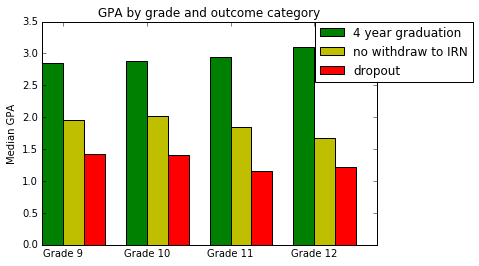

Plot created in /home/jgutman/mvesc/Descriptives/compare_gpa_graduates_noIRN_dropout.png


In [114]:
main()